## Preparation

In [2]:
%matplotlib inline
import nibabel as nib
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
%%bash
# download all the necessary files

# noise_idx
wget -q -O sub-controlGE140_ses-pre_task-flanker_bold_AROMAnoiseICs.csv https://osf.io/ye3dm/download/
# melodic_mix
wget -q -O sub-controlGE140_ses-pre_task-flanker_bold_MELODICmix.tsv https://osf.io/dq6jz/download/
# brainmask
wget -q -O sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz https://osf.io/vp8xz/download/
# raw_img (fmriprep output)
wget -q -O sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_preproc.nii.gz https://osf.io/wtzde/download/
# denoised_smooth_img (fmriprep output with --use-aroma)
wget -q -O sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz https://osf.io/kb468/download/
# denoised_img (calculated via fsl_regfilt with melodic_mix and noise_ics)
wget -q -O sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_variant-AROMAnonaggr_preproc.nii.gz https://osf.io/jyfxs/download/

In [4]:
# load all the files into python
noise_idx = np.loadtxt('./sub-controlGE140_ses-pre_task-flanker_bold_AROMAnoiseICs.csv', delimiter=",", dtype='int') - 1
melodic_mix = np.loadtxt('./sub-controlGE140_ses-pre_task-flanker_bold_MELODICmix.tsv')

# brainmask
brainmask_img = nib.load('./sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')
brainmask_data = brainmask_img.get_data().astype(bool)

# fmriprep output
raw_img = nib.load('./sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
raw_data = raw_img.get_data()
raw_data_masked = raw_data[brainmask_data]

# fmriprep output (denoised with ica-aroma)
denoised_smooth_img = nib.load('./sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz')
denoised_smooth_data = denoised_smooth_img.get_data()
denoised_smooth_data_masked = denoised_smooth_data[brainmask_data]

# calculated with fsl_regfilt
denoised_img = nib.load('./sub-controlGE140_ses-pre_task-flanker_bold_space-MNI152NLin2009cAsym_variant-AROMAnonaggr_preproc.nii.gz')
denoised_data = denoised_img.get_data()
denoised_data_masked = denoised_data[brainmask_data]


## reproduce Chris's python version of non-aggressive denoising

In [5]:
# split melodic_mix into noise and signal components
noise_components = melodic_mix[:,noise_idx]
signal_components = np.delete(melodic_mix, noise_idx, axis=1)

# reorganize the components into design
design = np.ones((315, 74))
design[:, 1:11] = signal_components
design[:, 12:74] = noise_components
unmixMatrix = np.linalg.pinv(design)

maps = np.dot(raw_data_masked, unmixMatrix.T)
noisemap = maps[:,np.r_[12:74]]
nonagg_res = np.dot(noise_components, noisemap.T)
newData_nonagg = raw_data_masked - nonagg_res.T

In [6]:
# compare newData_nonagg with denoised_data_masked
np.max(newData_nonagg - denoised_data_masked)
# they are almost identical, just rounding error differences.
# yay! confirms Chris's code

6.10352090006927e-05

## Testing
If I perform global signal regression, I can pull the average signal either from the raw_data (as is currently done in fmriprep) or I can pull it from the denoised_data. Then I can regress the global signal (either derived from the raw_data_masked or from the denoised_data_masked) from a test voxel in the denoised_data_mask dataset. Theoretically, the residual from such an analysis should be the same whether the global signal was calculated with raw_data_masked or denoised_data_masked. The regression would result in the same outcome because the only additional variance represented in the gs_raw that isn't represented in gs_denoised is the variance associated with the noise components, which denoised_data_masked is already orthagonal to meaning that additional variance shouldn't have an impact on the data.

**H0:** `y ~ gs_raw == y ~ gs_denoised`

**H1:** `y ~ gs_raw != y ~ gs_denoised`

In [7]:
# global signal
gs_raw = np.mean(raw_data_masked, axis=0)
gs_denoised = np.mean(denoised_data_masked, axis=0)

# example voxel from the denoised data
ex_denoised_coord = denoised_data_masked[500,:]

In [8]:
ts_dict = {'gs_raw': gs_raw, 'gs_denoised': gs_denoised, 'denoised_bold': ex_denoised_coord}
regression_df = pd.DataFrame(data=ts_dict)

# regression of the global signal (derived from raw_data_masked) from the example voxel
mod_raw = smf.ols(formula='denoised_bold ~ gs_raw', data=regression_df)
res_raw = mod_raw.fit()
resid_raw = res_raw.resid

# regression of the global signal (derived from denoised_data_masked) from the example voxel
mod_denoised = smf.ols(formula='denoised_bold ~ gs_denoised', data=regression_df)
res_denoised = mod_denoised.fit()
resid_denoised = res_denoised.resid

In [9]:
# there appears to be substantial difference between the two, supports H1
np.max(resid_raw - resid_denoised)

5.947608615006175

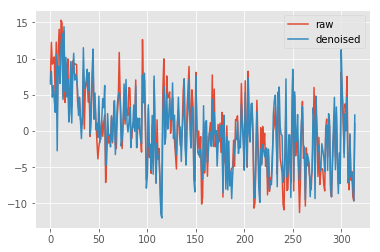

In [10]:
plt.plot(resid_raw, label='raw')
plt.plot(resid_denoised, label='denoised')
plt.legend()
# supports H1

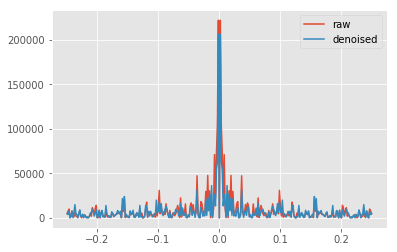

In [11]:
# plot out power spectrum for each residual time series
ps_raw = np.abs(np.fft.fft(resid_raw))**2
ps_denoised = np.abs(np.fft.fft(resid_denoised))**2
time_step = 1 / .5
freqs = np.fft.fftfreq(resid_raw.size, time_step)
idx = np.argsort(freqs)
plt.plot(freqs[idx], ps_raw[idx], label='raw')
plt.plot(freqs[idx], ps_denoised[idx], label='denoised')
plt.legend()
# supports H1

## Conclusion

There appears to be a difference between the two methods, but please check my work, I'm not confident in the models I set up.